# About

While the ability of reservoir computers to predict the temporal evolution of certain dynamical systems has been demonstrated extensively, it is notably limited to the portion of the phase space that the reservoir is shown during the learning process, since the parameters of the underlying system have already been set ad hoc. This problem is further exacerbated when the training data is short in time and stochastic, such as a series of experimental datasets which may not even share the exact same statistics.

The notebook in this repository provides the option to implement a parallel reservoir computer architecture that incorporates knowledge about the existing network structure of the dynamical system that is to be predicted. This is done with a series of smaller reservoirs that each predict a small portion of the entire input network, whilst using its closest neighborhood nodes as part of the feedback. 

For instance, a cell's boundary that has been discretized to 400 points can be predicted with 10 reservoirs, each predicting 40 of the points whilst incorporating its nearest 5 points as feedback. This scheme not only ameliorates the difficulty of the reservoir to predict all of the input dimensions at once, which themselves can exhibit a high degree of stochaticism and other experimental artifacts depending on the type of data; but also better entrains the reserevoir to the local dynamics, as the number of neighbors sampled in the adjacency and input matrices decrease (and thus prohibits coupling between distant network nodes).

# Import packages

In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sparse
from scipy.stats import pearsonr
from scipy.sparse import linalg
from scipy.linalg import solve, pinv
from scipy.signal import savgol_filter
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rc
import matplotlib.gridspec as gridspec
from functools import partial
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import time
from numpy.fft import fft2, fftshift, ifft2


from scipy.integrate import solve_ivp

## Generate training set from Lorenz

In [2]:
# reservoir computers are good for predicting periodic systems/input data
# s permits online training
def lorenz(xyz, *, s=10, r=28, b=8/3): # dictates the pattern that it should predict
    """
    Parameters
    ----------
    xyz : array-like, shape (3,)
       Point of interest in three-dimensional space.
    s, r, b : float
       Parameters defining the Lorenz attractor.

    Returns
    -------
    xyz_dot : array, shape (3,)
       Values of the Lorenz attractor's partial derivatives at *xyz*.
    """
    x, y, z = xyz
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return np.array([x_dot, y_dot, z_dot])


dt = .01
num_steps = 20000-1

xyzs = np.empty((num_steps + 1, 3))  # Need one more for the initial values
xyzs[0] = (0., 1., 0.)  # Set initial values
# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt

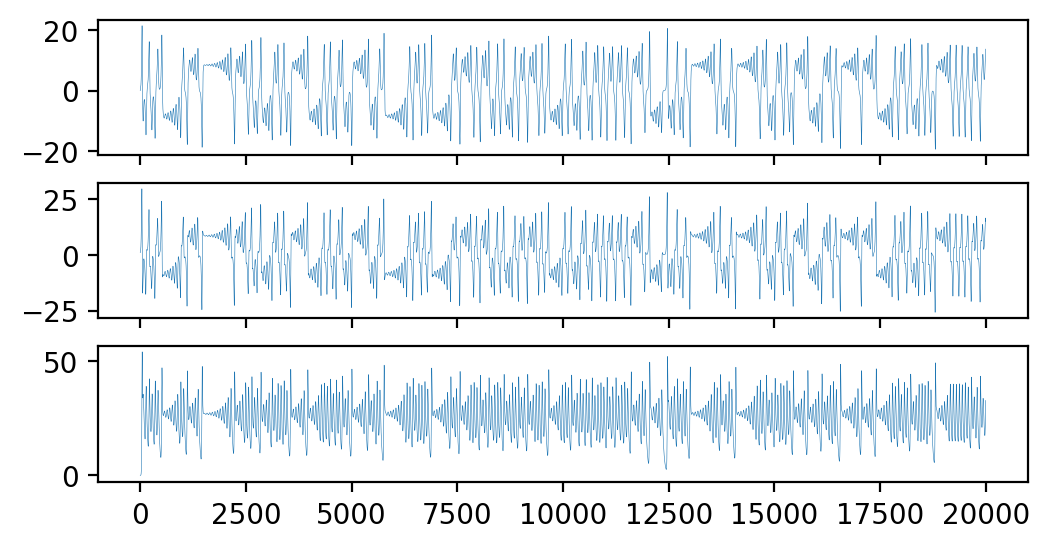

In [3]:

f, (ax0,ax1,ax2) = plt.subplots(3, figsize=(6,3), dpi=200,sharex=True)
f.patch.set_facecolor('xkcd:white')

a = ax0.plot(np.transpose(xyzs)[0],linewidth=.2)
b = ax1.plot(np.transpose(xyzs)[1],linewidth=.2)
c = ax2.plot(np.transpose(xyzs)[2],linewidth=.2)

In [216]:
# pd.DataFrame(xyzs).to_csv("lorenz.csv")

# Data cleanup

Define the markers which designate the time points in which the burning stage should be initiated.

In [4]:
marker=np.array(([0]))
np.shape(marker)

(1,)

In [5]:
test=np.transpose(xyzs) # IMPORTANT: 'test' is just the training data. i just called it 'test' because it was a trial array at the time. 

train_input=test[:,:-2000]
val = test[:,-2000:]



marker=np.array(([0]))

input_size = test.shape[0] # spatial dimensions of the dataset




transient_length = 30 # how long I am setting the synchronization period

# The training data without the synchronization periods. 
# This will be used later when we regress the output matrix, during the final stages of trianing.
train_input_fin=np.zeros((train_input.shape[0],train_input.shape[1]-marker.shape[0]*transient_length)) # only regression

for i in range(marker.shape[0]): # remove transient
    if i!=(marker.shape[0]-1):
        for t in range(marker[i]-i*transient_length,marker[i+1]-(i+1)*transient_length):
            train_input_fin[:,t]=train_input[:,t+(i+1)*transient_length]
    else:
        for t in range(marker[i]-(i)*transient_length,train_input.shape[1]-marker.shape[0]*transient_length):
            train_input_fin[:,t]=train_input[:,t+(i+1)*transient_length]



In [6]:


# ##############     Generate separate test data     ####################################


# num_steps = 2000-1

# xyzs = np.empty((num_steps + 1, 3))  # Need one more for the initial values
# xyzs[0] = (0., 1.01, 1.015) # Set initial values

# for i in range(num_steps):
#     xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt
    
# ##################################################################################################
    
# val =np.transpose(xyzs)

# I sometimes permit a longer sync period specifically for the validation data,
# (cont.) since the dynamics in experimental settigns can be bit different from the training set.

val_skip=1 # val_skip * transient length = transient cutoff for prediction


# Fully closed prediction (global predictability)

1. __input_weight__ controls the range of values the input matrix can take. Specifically, the nonzero values of the input matrix __win__ are chosen from a uniform distribution (np.random.rand chooses a uniform distribution from 0 to 1, such that -1+2 * rand will generate a distribution from -1 to 1) that is then rescaled such that the range spans from -input_weight to +input_weight

2. __spectral_radius__ controls how much each node in the reservoir "talks" to each other. This is desired to be set to be as close to, but below, 1, to maintain ergodicity.

3. __regularization__ is the Tikhonov regularization parameter that is used as part of the regression to obtain the trained output matrix. This penalizes any large terms of the output matrix __wout__, thereby preventing overfitting to any particular prediction.

4. __average_degree__ is the average number of nodes any particular node in the reservoir is connected to. We note in passing that the node can talk to itself as well.

5. __leakage__ describes the amount of memory the reservoir maintains of its previous state as it updates, and thus controls the amount of hysteresis the reservoir exhibits. Because it controls the memory of the reservoir, it also serves to characterize the damping of the system---for small leakage, the reservoir is allowed to oscillate freely with every step; as the leakage increases, the reservoir's prior state reigns in this behaviour.

6. __num_res__ describes the number of reservoirs in the system.  It is important that you choose this value such that __input_size__ be a multiple of __num_res__, evidently for both heuristic and logical reasons.

7. __overlap__ determines the number of neighboring inputs each reservoir samples on "either side". While there is no limit as to what this value can be, it is important that you choose __num_nodes_tot_approx__ to be a large enough value such that there exists at least one nonzero element of __win__ for each reservoir node. As a sanity check, in the limiting case of one reservoir, the minimum number of nodes for this to happen based on our construction and our input_size of 400 boundary points is 400 nodes (num_res=1, overlap=0).

## Step by step

Learning complete!
Now predicting...


  0%|          | 0/1999 [00:00<?, ?it/s]

Text(0.5, 1.0, 'prediction (orange)')

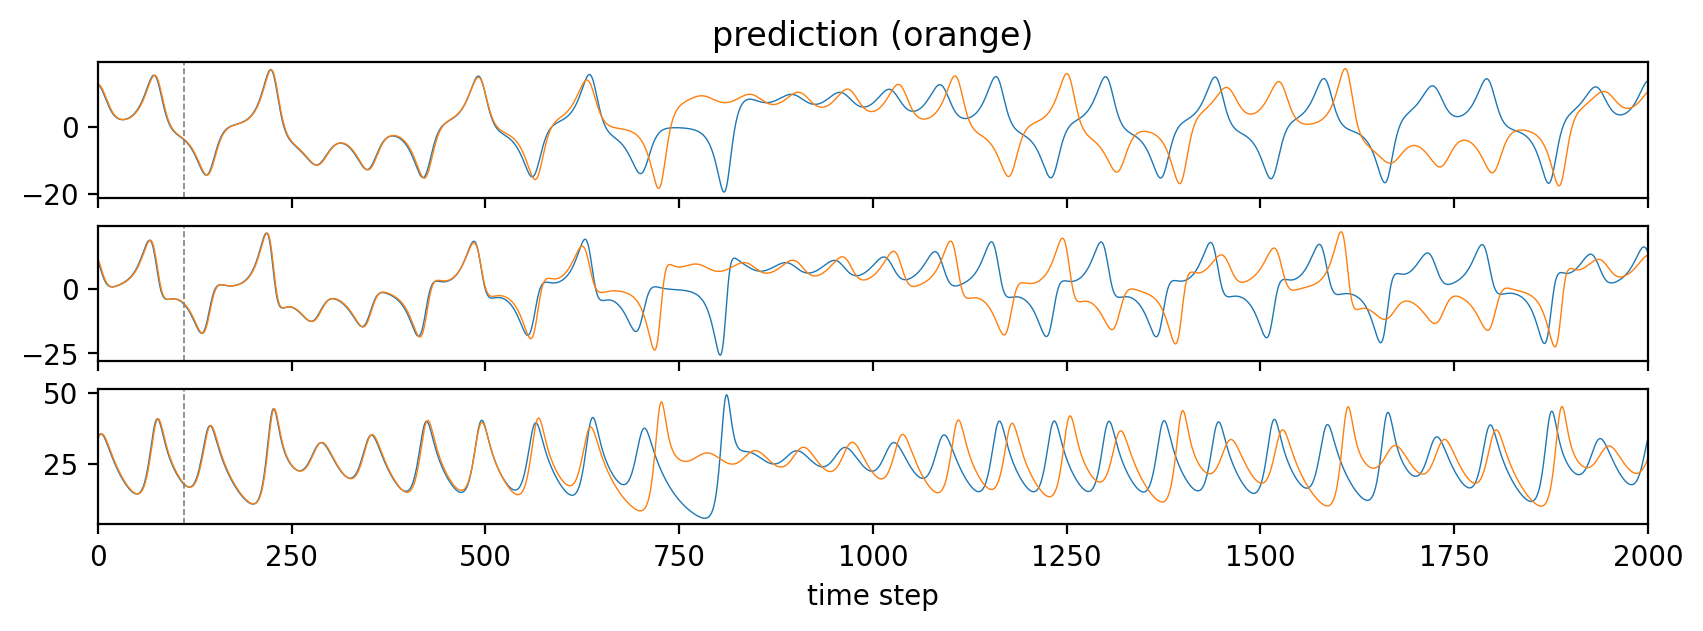

In [19]:
# HYPERPARAMETERS; conditions/design of "classroom"
# TO DO: try altering these hyperparams
# leakage = how fast each node is responding -> optimal value depends on timescale of dynamics -> change dt
data_seed=30
np.random.seed(data_seed)

# e = exponential
input_weight=1e-2
regularization=1.1e-12
leakage=0.1 # -> timing/delay?
spectral_radius=2

    
###################################################################################################
# for parallel
bias= 0


num_res=1
num_nodes_tot_approx=300 # should be > (int(np.ceil(input_size/num_res))+overlap*2)*num_res
num_nodes=int(num_nodes_tot_approx/num_res)
num_nodes_tot=num_nodes*num_res
overlap=0

average_degree=6



# ###################################################################################################
# define matrices based on params

A_mat = sparse.random(num_nodes,num_nodes, density = average_degree/num_nodes, random_state=data_seed)
eg = linalg.eigs(A_mat, k = 1, return_eigenvectors=False)
A_mat = spectral_radius/np.abs(eg[0])*A_mat

# A_mat = 2*A_mat - A_mat.ceil() #redefines A_mat to range from -1 to 1
# eigenvectors define stability
# determinant relates to volume of matrix (product of elems)
# largest A = spectral radius

q = int(np.floor(num_nodes/(int(np.ceil(input_size/num_res))+overlap*2))) # equally distribute throughout dimensions

win = np.zeros((num_nodes,int(np.ceil(input_size/num_res))+overlap*2))
for i in range(int(np.ceil(input_size/num_res))+overlap*2):
    np.random.seed(i)
    ip = (-1 + 2*np.random.rand(q));
    win[i*q:(i+1)*q,i] = input_weight*ip;
    
###################################################################################################



# randomized bias: you can choose to have a single bias factor multiplied by a vector w elements between [0,1] if you'd like.


bias_vector = bias # shift window so that it oscillates w/in dynamic range (instead of dead/epileptic firing); small value, trial and error

# bias_vector = np.zeros((num_nodes))
# for i in range(num_nodes):
#     np.random.seed(i+2)
#     ip = (-1 + 2*np.random.rand(1));
#     bias_vector[i] = bias*ip;


###################################################################################################
# reservoir evolution equation (state update)
def advanceReservoir(win,A_mat,x,u,leakage):
    x_next = leakage*x + (1-leakage)*np.tanh(A_mat.dot(x) + np.matmul(win,u)+bias_vector)
    return x_next
    
###################################################################################################




x = np.zeros((num_res,num_nodes)) # init state of reservoir

states = np.zeros((num_res,num_nodes, train_input.shape[1]-marker.shape[0]*transient_length)) # recorded states

###   Transience / sync / burning period ###


for num in range(num_res):
    
    # indices for parallel
    lower = int(np.ceil(input_size/num_res))*num-overlap
    upper = int(np.ceil(input_size/num_res))*(num+1)+overlap
    
    ### FOR RESERVOIRS THAT SAMPLE PAST THE BOUNDARY ###
    if lower <0 or upper > input_size:  
        
        ## synchronization ##
        for i in range(marker.shape[0]):
            for t in range(transient_length):     
                x[num] = advanceReservoir(win,A_mat,x[num,k],\
                                            np.concatenate((train_input[lower%input_size:input_size],\
                                                           train_input[0:upper%input_size]),axis=0)\
                                                              [:,t+marker[i]],\
                                                              leakage)
            ## sets initial training state for recording ##
            states[num,:,marker[i]-i*transient_length] = x[num]; 

            
            ###  train  ###
            if i!=(marker.shape[0]-1):
                # train between markers
                for t in range(marker[i]-i*transient_length,marker[i+1]-(i+1)*transient_length-1):
                    states[num,:,t+1] = advanceReservoir(win,A_mat,states[num,:,t],\
                                                            np.concatenate((train_input[lower%input_size:input_size],\
                                                                            train_input[0:upper%input_size]),axis=0)\
                                                              [:,t+(i+1)*transient_length],\
                                                       leakage)
                    
                ##  initializes the starting x (to start burn again) as the final state in previous data  ##  
                x[num] = states[num,:,marker[i+1]-(i+1)*transient_length-1] 
                    
                    
                    
            ## training the last segment to the end of the training dataset
            else: 

                for t in range(marker[i]-(i)*transient_length,train_input.shape[1]-marker.shape[0]*transient_length-1):
                    states[num,:,t+1] = advanceReservoir(win,A_mat,states[num,:,t],\
                                                            np.concatenate((train_input[lower%input_size:input_size],\
                                                                            train_input[0:upper%input_size]),axis=0)\
                                                              [:,t+(i+1)*transient_length],\
                                                       leakage)
                x[num] = states[num,:,train_input.shape[1]-marker.shape[0]*transient_length-1] 

    
    
    
    ### FOR ALL OTHER RESERVOIRS ###
    else: 
       
        ## sync ##
        for i in range(marker.shape[0]):
            for t in range(transient_length):
                 x[num] = advanceReservoir(win,A_mat,x[num],\
                                            train_input[lower:\
                                                        upper,t+marker[i]],\
                                           leakage)  

            ## sets initial training state for recording ##        
            states[num,:,marker[i]-i*transient_length] = x[num]; 


            ###   train   ###
            if i!=(marker.shape[0]-1):

                for t in range(marker[i]-i*transient_length,marker[i+1]-(i+1)*transient_length-1):
                    states[num,:,t+1] = advanceReservoir(win,A_mat,states[num,:,t],\
                                                                    train_input[lower:\
                                                                                upper,\
                                                                                t+(i+1)*transient_length],\
                                                                    leakage)
                x[num] = states[num,:,marker[i+1]-(i+1)*transient_length-1] 

            else:

                for t in range(marker[i]-(i)*transient_length,train_input.shape[1]-marker.shape[0]*transient_length-1):
                    states[num,:,t+1] = advanceReservoir(win,A_mat,states[num,:,t],\
                                                                    train_input[lower:\
                                                                                upper,\
                                                                                t+(i+1)*transient_length],\
                                                                    leakage)
                x[num] = states[num,:,train_input.shape[1]-marker.shape[0]*transient_length-1]
                
 # regression stage (filter nodes for best ones)               
idenmat = regularization*sparse.identity(num_nodes) # higher regularizatipn -> penalize high elements -> decreases contrast
s_mat = np.identity(train_input.shape[1]-marker.shape[0]*transient_length)
# s_mat = np.diag(np.power(forget,np.arange(train_length)[::-1])) #this permits online learning
wout=np.zeros((num_res,int(np.ceil(input_size/num_res)),num_nodes))



for num in range(num_res):

    data_trstates= np.matmul(np.matmul(train_input_fin[(int(np.ceil(input_size/num_res))*num):(int(np.ceil(input_size/num_res))*(num+1))],s_mat),np.transpose(states[num]))
    # Y_target * X^T

    states_trstates= np.matmul(np.matmul(states[num],s_mat),np.transpose(states[num]))
    states_trstates_inv = pinv(states_trstates + idenmat)

    wout[num]= np.matmul(data_trstates,states_trstates_inv) 
    # (X X^T + βI)^(-1)



print("Learning complete!")
print("Now predicting...")  
    


            
####### IF USING END OF TRAINING SET (YET UNSEEN) AS TEST SET #########

# last point of training = starting point for validation
x_val=x
val_skip=0

#######################################################################

length=val.shape[1]-val_skip*transient_length

prediction = np.zeros((num_res,wout.shape[1],length))
pred_concat = np.zeros((num_res,wout.shape[1],length))
prediction_iteration = np.zeros((num_res,wout.shape[1]))      


####### IF USING COMPLETELY NEW DATSET AS TEST DATA #########

# x_val=np.zeros((num_res,num_nodes))


# # burning in the validation data
# for t in range(val_skip*transient_length):      

#     for num in range(num_res):
        
#         lower = int(np.ceil(input_size/num_res))*num-overlap
#         upper = int(np.ceil(input_size/num_res))*(num+1)+overlap

#         if lower <0 or upper > input_size:  
#             x_val[num] = advanceReservoir(win,A_mat,x_val[num],\
#                                                 np.concatenate((val[lower%input_size:input_size],\
#                                                                val[0:upper%input_size]),axis=0)\
#                                                                   [:,t],\
#                                                                   leakage)        

#         else:

#             x_val[num] = advanceReservoir(win,A_mat,x_val[num],val[lower:\
#                                                             upper,t],\
#                                                               leakage)        


#####################################
    
##  last point of transience (basically using t = -1 data to get x_val at t=0, for pred at t=0)  ##            
for num in range(num_res):
    prediction_iteration[num] = np.matmul(wout[num],x_val[num]) 
    prediction[num,:,0] = prediction_iteration[num]

    
    
### concatenate all the reservoirs ###
pred_concat=np.concatenate(prediction_iteration)





x=x_val


### commence prediction ###

pbar=tqdm_notebook(total=length-1)
for t in range(0,length-1):    
    
        
    for num in range(num_res):
        
        lower = int(np.ceil(input_size/num_res))*num-overlap
        upper = int(np.ceil(input_size/num_res))*(num+1)+overlap

        if lower < 0 or upper > input_size:  

            x[num] = advanceReservoir(win, A_mat, x[num], \
                                        np.concatenate((pred_concat[lower%input_size:input_size],\
                                                       pred_concat[0:upper%input_size]),axis=0),\
                                        leakage)

        else:

            x[num] = advanceReservoir(win, A_mat, x[num], \
                                      pred_concat[lower:\
                                                  upper], \
                                      leakage)


    for num in range(num_res):
        prediction_iteration[num] = np.matmul(wout[num],x[num]) # append prediction array with output y(t) = W_out x(t)
        prediction[num,:,t+1]=prediction_iteration[num]

    pred_concat=np.concatenate(prediction_iteration)
       
                
    pbar.update(1)
    
####################################


f, (ax0,ax1,ax2) = plt.subplots(3, figsize=(10,3), dpi=200,sharex=True)
f.patch.set_facecolor('xkcd:white')

a = ax0.plot(val[0,val_skip*transient_length:],linewidth=.5)
ax0.plot(np.concatenate(prediction,axis=0)[0,:],linewidth=.5)
b = ax1.plot(val[1,val_skip*transient_length:],linewidth=.5)
ax1.plot(np.concatenate(prediction,axis=0)[1,:],linewidth=.5)
c = ax2.plot(val[2,val_skip*transient_length:],linewidth=.5)
ax2.plot(np.concatenate(prediction,axis=0)[2,:],linewidth=.5)

ax0.axvline(x = 1/(dt*.9056), color = 'gray', linestyle = 'dashed',linewidth=.6)
ax1.axvline(x = 1/(dt*.9056), color = 'gray', linestyle = 'dashed',linewidth=.6)
ax2.axvline(x = 1/(dt*.9056), color = 'gray', linestyle = 'dashed',linewidth=.6)

plt.xlim(0,val[:,val_skip*transient_length:].shape[1])

plt.xlabel("time step")
ax0.set_title("prediction (orange)")



Text(0.5, 1.0, 'error')

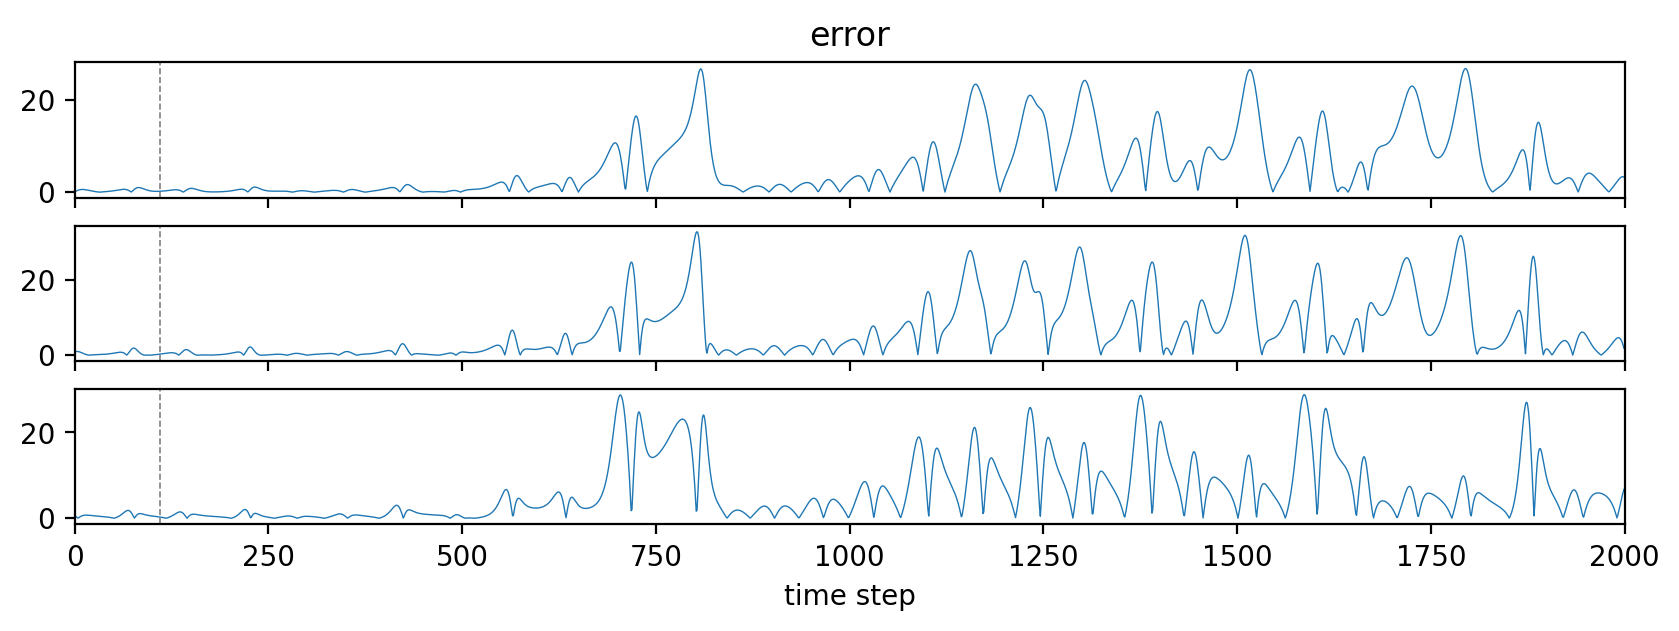

In [20]:

f, (ax0,ax1,ax2) = plt.subplots(3, figsize=(10,3), dpi=200,sharex=True)
f.patch.set_facecolor('xkcd:white')

a = ax0.plot(np.abs(np.concatenate(prediction,axis=0)[0,:]-val[0,val_skip*transient_length:]),linewidth=.5)
b = ax1.plot(np.abs(np.concatenate(prediction,axis=0)[1,:]-val[1,val_skip*transient_length:]),linewidth=.5)
c = ax2.plot(np.abs(np.concatenate(prediction,axis=0)[2,:]-val[2,val_skip*transient_length:]),linewidth=.5)

ax0.axvline(x = 1/(dt*.9056), color = 'gray', linestyle = 'dashed',linewidth=.6)
ax1.axvline(x = 1/(dt*.9056), color = 'gray', linestyle = 'dashed',linewidth=.6)
ax2.axvline(x = 1/(dt*.9056), color = 'gray', linestyle = 'dashed',linewidth=.6)

plt.xlim(0,val[:,val_skip*transient_length:].shape[1])

plt.xlabel("time step")
ax0.set_title("error")



In [22]:
#first instance when error exceeds some value

error_threshold=2

np.argmax(np.abs(np.concatenate(prediction,axis=0)[0,:]-val[0,val_skip*transient_length:])>error_threshold)

547

In [235]:
# DW about this for now; can change # of noes
# r, b can change it from chaotic to stable
# N0 nodes that give the highest values of Wout, per spatial dim.
N0=3

def smallestN_indices(a, N):
    idx = a.ravel().argsort()[:N]
    return np.stack(np.unravel_index(idx, a.shape)).T


# number of links attached to these most influential nodes (1st axis: spatial dim, 2nd: sorted by most influential)
most_influence_mod = np.zeros((input_size,N0))

which_res=0 # to choose which mini res to read highest values of wout from

for dim in range(input_size): #across spatial dim
    for n in range(N0):
        most_influence_mod[dim,n]=smallestN_indices(np.abs(1/wout[which_res,dim]),N=N0)[n][0]
        
print(most_influence_mod)

[[ 72.  53.   7.]
 [219. 240. 278.]
 [292. 218. 232.]]
